In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from catboost import CatBoostRegressor

In [ ]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [ ]:
# df = pd.read_csv('data_science_salaries.csv')
# df['work_year'] = pd.to_numeric(df['work_year'], errors='coerce')
# df['salary'] = pd.to_numeric(df['salary'], errors='coerce')
# df['salary_in_usd'] = pd.to_numeric(df['salary_in_usd'], errors='coerce')
import pandas as pd
import kagglehub

# Скачиваем датасет с Kaggle
path = kagglehub.dataset_download("sazidthe1/data-science-salaries")
print("Path to dataset files:", path)

# Загружаем CSV в DataFrame
df = pd.read_csv(f"{path}/data_science_salaries.csv")

# Приводим нужные колонки к числовому типу
df['work_year'] = pd.to_numeric(df['work_year'], errors='coerce')
df['salary'] = pd.to_numeric(df['salary'], errors='coerce')
df['salary_in_usd'] = pd.to_numeric(df['salary_in_usd'], errors='coerce')

# Проверяем
print(df.info())
print(df.head())


100%|██████████| 57.3k/57.3k [00:00<00:00, 32.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/sazidthe1/data-science-salaries/versions/2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6599 entries, 0 to 6598
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   job_title           6599 non-null   object
 1   experience_level    6599 non-null   object
 2   employment_type     6599 non-null   object
 3   work_models         6599 non-null   object
 4   work_year           6599 non-null   int64 
 5   employee_residence  6599 non-null   object
 6   salary              6599 non-null   int64 
 7   salary_currency     6599 non-null   object
 8   salary_in_usd       6599 non-null   int64 
 9   company_location    6599 non-null   object
 10  company_size        6599 non-null   object
dtypes: int64(3), object(8)
memory usage: 567.2+ KB
None
        job_title experience_level employment_type work_models  work_year  \
0   Data Engineer

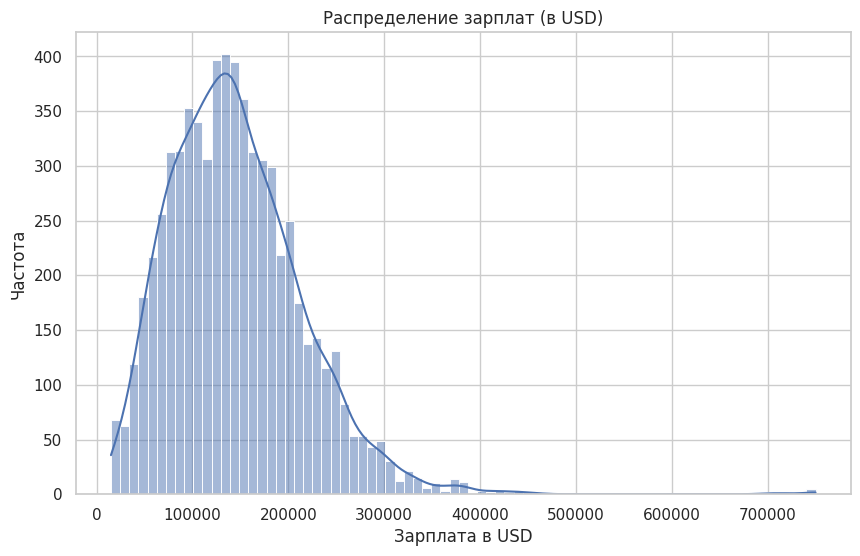

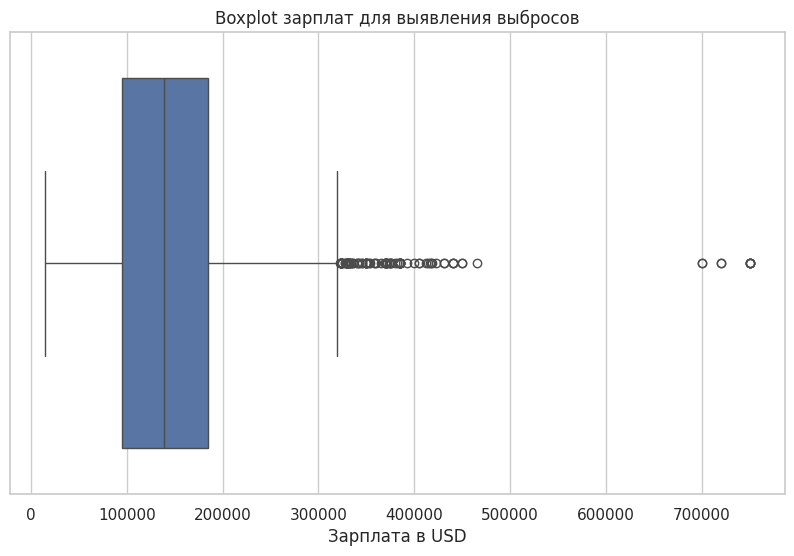

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['salary_in_usd'], kde=True)
plt.title('Распределение зарплат (в USD)')
plt.xlabel('Зарплата в USD')
plt.ylabel('Частота')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['salary_in_usd'])
plt.title('Boxplot зарплат для выявления выбросов')
plt.xlabel('Зарплата в USD')
plt.show()

In [ ]:
df = df.drop(['salary', 'salary_currency'], axis=1)

# Обработка выбросов с помощью метода IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_clean = remove_outliers(df, 'salary_in_usd')
print(f"Размер датасета после удаления выбросов: {df_clean.shape[0]} записей (удалено {df.shape[0] - df_clean.shape[0]} выбросов)")

Размер датасета после удаления выбросов: 6492 записей (удалено 107 выбросов)


In [ ]:
df_fe = df_clean.copy()

# 1. Уменьшение размерности job_title
def simplify_job_title(title):
    title = str(title).lower()
    if 'scientist' in title or 'research' in title:
        return 'Data Scientist'
    elif 'engineer' in title or 'architect' in title:
        return 'Data Engineer'
    elif 'analyst' in title or 'bi' in title:
        return 'Data Analyst'
    elif 'ml' in title or 'machine learning' in title or 'ai' in title:
        return 'ML Engineer'
    else:
        return 'Other'

df_fe['simplified_job_title'] = df_fe['job_title'].apply(simplify_job_title)
print("\nРаспределение упрощенных должностей:")
print(df_fe['simplified_job_title'].value_counts())

# 2. Создание бинарных признаков для стран
df_fe['is_usa_residence'] = df_fe['employee_residence'].apply(lambda x: 1 if str(x) == 'United States' else 0)
df_fe['is_usa_company'] = df_fe['company_location'].apply(lambda x: 1 if str(x) == 'United States' else 0)

# 3. Создание признака опыта в годах
year = 2020
df_fe['experience_years'] =  df_fe['work_year'] - year

# 4. Взаимодействие признаков
df_fe['exp_level_size'] = df_fe['experience_level'].astype(str) + '_' + df_fe['company_size'].astype(str)

# 5. Сокращение количества категорий в странах
def simplify_country(country):
    country = str(country)
    if country == 'United States':
        return 'USA'
    elif country in ['Canada', 'United Kingdom', 'Australia', 'Germany', 'France']:
        return 'Developed'
    else:
        return 'Other'

df_fe['simplified_residence'] = df_fe['employee_residence'].apply(simplify_country)
df_fe['simplified_company_loc'] = df_fe['company_location'].apply(simplify_country)


Распределение упрощенных должностей:
simplified_job_title
Data Engineer     2784
Data Scientist    1892
Data Analyst      1161
Other              612
ML Engineer         43
Name: count, dtype: int64


In [ ]:
# Определение категориальных и числовых признаков
categorical_features = [
    'simplified_job_title', 'experience_level', 'employment_type',
    'work_models', 'employee_residence', 'company_location',
    'company_size', 'simplified_residence', 'simplified_company_loc', 'exp_level_size'
]

# Числовые признаки
numerical_features = ['work_year', 'experience_years', 'is_usa_residence', 'is_usa_company']

# Целевая переменная
target = 'salary_in_usd'

# Разделение на признаки и целевую переменную
X = df_fe[categorical_features + numerical_features]
y = df_fe[target]

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

In [ ]:
results = {
    'Model': [],
    'MAE': [],
    'RMSE': [],
    'R²': []
}

In [ ]:
# 1. Линейная регрессия
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict(X_test)

results['Model'].append('Linear Regression')
results['MAE'].append(mean_absolute_error(y_test, lr_pred))
results['RMSE'].append(np.sqrt(mean_squared_error(y_test, lr_pred)))
results['R²'].append(r2_score(y_test, lr_pred))

In [ ]:
# 2. Случайный лес с GridSearchCV
print("\nЗапуск GridSearchCV для Random Forest...")
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Сетка параметров для Random Forest
rf_param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

rf_grid_search = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train, y_train)

# Используем лучшую модель
best_rf = rf_grid_search.best_estimator_
rf_pred = best_rf.predict(X_test)

print(f"Лучшие параметры для Random Forest: {rf_grid_search.best_params_}")
print(f"Лучший R² на кросс-валидации: {rf_grid_search.best_score_:.4f}")

results['Model'].append('Random Forest ( tuned)')
results['MAE'].append(mean_absolute_error(y_test, rf_pred))
results['RMSE'].append(np.sqrt(mean_squared_error(y_test, rf_pred)))
results['R²'].append(r2_score(y_test, rf_pred))




Запуск GridSearchCV для Random Forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Лучшие параметры для Random Forest: {'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 50}
Лучший R² на кросс-валидации: 0.3489


In [ ]:
# 3. XGBoost
print("\nЗапуск GridSearchCV для XGBoost...")
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(random_state=42, n_jobs=-1))
])


xgb_param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__max_depth': [3, 6],
    'regressor__subsample': [0.8, 1.0]
}

xgb_grid_search = GridSearchCV(
    xgb_pipeline,
    xgb_param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

xgb_grid_search.fit(X_train, y_train)

best_xgb = xgb_grid_search.best_estimator_
xgb_pred = best_xgb.predict(X_test)

print(f"Лучшие параметры для XGBoost: {xgb_grid_search.best_params_}")
print(f"Лучший R² на кросс-валидации: {xgb_grid_search.best_score_:.4f}")

results['Model'].append('XGBoost (tuned)')
results['MAE'].append(mean_absolute_error(y_test, xgb_pred))
results['RMSE'].append(np.sqrt(mean_squared_error(y_test, xgb_pred)))
results['R²'].append(r2_score(y_test, xgb_pred))



Запуск GridSearchCV для XGBoost...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Лучшие параметры для XGBoost: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}
Лучший R² на кросс-валидации: 0.3640


In [ ]:
# 4. CatBoost

catboost_features = [
    'job_title', 'experience_level','simplified_residence',
    'work_models', 'employee_residence', 'company_location',
    'company_size', 'simplified_job_title',
    'exp_level_size'
]


X_train_cat = df_fe.loc[X_train.index][catboost_features]
X_test_cat = df_fe.loc[X_test.index][catboost_features]

categorical_features_for_catboost = [
    'job_title', 'experience_level', 'simplified_residence',
   'work_models', 'employee_residence', 'company_location',
    'company_size', 'simplified_job_title',  'exp_level_size'
]

catboost_param_grid = {
    'iterations': [400],
    'learning_rate': [0.05],
    'depth': [7],
    'l2_leaf_reg': [2],
    'border_count': [50],
    'bagging_temperature': [0.5]
}

print("Параметры для поиска:")
for param, values in catboost_param_grid.items():
    print(f"  {param}: {values}")

from itertools import product
param_combinations = list(product(*catboost_param_grid.values()))
param_names = list(catboost_param_grid.keys())

print(f"\nВсего комбинаций для проверки: {len(param_combinations)}")

best_score = -np.inf
best_params = None
best_model = None

kf = KFold(n_splits=3, shuffle=True, random_state=42)

all_results = []

for i, params in enumerate(param_combinations):
    param_dict = dict(zip(param_names, params))

    fold_scores = []
    early_stop = False

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_cat)):
        if early_stop:
            break

        X_tr, X_val = X_train_cat.iloc[train_idx], X_train_cat.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = CatBoostRegressor(
            **param_dict,
            cat_features=categorical_features_for_catboost,
            verbose=0,
            random_state=42,
            early_stopping_rounds=20  # Ранняя остановка для ускорения
        )

        model.fit(X_tr, y_tr, eval_set=(X_val, y_val))

        train_score = r2_score(y_tr, model.predict(X_tr))
        val_score = r2_score(y_val, model.predict(X_val))

        if train_score - val_score > 0.2:
            early_stop = True
            continue

        fold_scores.append(val_score)

    if not fold_scores or early_stop:
        continue

    mean_score = np.mean(fold_scores)

    all_results.append((param_dict, mean_score))

    print(f"Комбинация {i+1}/{len(param_combinations)}: R² = {mean_score:.4f}")
    print(f"  Параметры: {param_dict}")

    if mean_score > best_score:
        best_score = mean_score
        best_params = param_dict
        catboost_model = CatBoostRegressor(
            **param_dict,
            cat_features=categorical_features_for_catboost,
            verbose=0,
            random_state=42
        )
        catboost_model.fit(X_train_cat, y_train)


print(f"\nЛучшие параметры для CatBoost: {best_params}")
print(f"Лучший R² на кросс-валидации: {best_score:.4f}")

catboost_pred = catboost_model.predict(X_test_cat)

results['Model'].append('CatBoost')
results['MAE'].append(mean_absolute_error(y_test, catboost_pred))
results['RMSE'].append(np.sqrt(mean_squared_error(y_test, catboost_pred)))
results['R²'].append(r2_score(y_test, catboost_pred))

# {'iterations': 400, 'learning_rate': 0.05, 'depth': 7, 'l2_leaf_reg': 2, 'border_count': 50, 'bagging_temperature': 0.5}

Параметры для поиска:
  iterations: [400]
  learning_rate: [0.05]
  depth: [7]
  l2_leaf_reg: [2]
  border_count: [50]
  bagging_temperature: [0.5]

Всего комбинаций для проверки: 1
Комбинация 1/1: R² = 0.3995
  Параметры: {'iterations': 400, 'learning_rate': 0.05, 'depth': 7, 'l2_leaf_reg': 2, 'border_count': 50, 'bagging_temperature': 0.5}

Лучшие параметры для CatBoost: {'iterations': 400, 'learning_rate': 0.05, 'depth': 7, 'l2_leaf_reg': 2, 'border_count': 50, 'bagging_temperature': 0.5}
Лучший R² на кросс-валидации: 0.3995


In [ ]:
# ================================
# Дашборды и схемы для раздела "Модели, настройка гиперпараметров и результаты"
# ================================
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
os.makedirs("figures", exist_ok=True)

# --- 0) Таблица результатов (если у вас только dict `results`, соберем DataFrame)
if 'results_df' not in globals():
    results_df = pd.DataFrame(results)

# Сохраним таблицу результатов
results_df_rounded = results_df.copy()
for col in ["MAE", "RMSE", "R²"]:
    results_df_rounded[col] = results_df_rounded[col].astype(float).round(4)
results_df_rounded.to_csv("figures/model_results.csv", index=False)

# Определим лучшую модель по R^2
best_model_idx = results_df["R²"].idxmax()
best_model_name = results_df.loc[best_model_idx, "Model"]
print(f"[Best model by R²] {best_model_name} (R²={results_df.loc[best_model_idx,'R²']:.4f})")

# --- 1) Сравнение моделей: MAE / RMSE / R² (горизонтальные барчарты)
def barh_metric(df, metric, fname, title):
    order = df.sort_values(metric, ascending=(metric != "R²"))["Model"]
    plt.figure(figsize=(10, 5.5))
    ax = sns.barplot(
        data=df,
        y="Model", x=metric,
        order=order,
        orient="h"
    )
    ax.set_title(title)
    ax.set_xlabel(metric)
    ax.set_ylabel("")
    for p in ax.patches:
        w = p.get_width()
        ax.annotate(f"{w:.3f}", (w, p.get_y() + p.get_height()/2.),
                    ha='left', va='center', fontsize=9, xytext=(3,0),
                    textcoords='offset points')
    plt.tight_layout()
    plt.savefig(f"figures/{fname}", dpi=300, bbox_inches="tight")
    plt.close()

barh_metric(results_df, "MAE",  "model_compare_mae.png",  "Сравнение моделей по MAE (меньше — лучше)")
barh_metric(results_df, "RMSE", "model_compare_rmse.png", "Сравнение моделей по RMSE (меньше — лучше)")
barh_metric(results_df, "R²",   "model_compare_r2.png",   "Сравнение моделей по R² (больше — лучше)")
print("saved: model_compare_mae.png, model_compare_rmse.png, model_compare_r2.png")

# --- 2) Теплокарты гиперпараметров RandomForest и XGBoost на базе cv_results_
def heatmap_from_cv(cv, index_param, col_param, agg_over=None, title="", fname="heatmap.png"):
    """Создает теплокарту mean_test_score по двум осям параметров.
       Если agg_over задан, усреднит по остальным гиперпараметрам."""
    cvres = pd.DataFrame(cv.cv_results_)
    cvres["mean_test_score"] = cvres["mean_test_score"].astype(float)
    # Переименуем столбцы параметров в короткие имена
    param_cols = [c for c in cvres.columns if c.startswith("param_")]
    rename_map = {c: c.replace("param_regressor__", "") for c in param_cols}
    cvres = cvres.rename(columns=rename_map)

    group_cols = [index_param, col_param]
    if agg_over:
        # Игнорируем остальные параметры, усредняя по ним
        pivot_df = (cvres
                    .groupby(group_cols)["mean_test_score"]
                    .mean()
                    .reset_index())
    else:
        pivot_df = cvres[group_cols + ["mean_test_score"]]

    pivot = pivot_df.pivot(index=index_param, columns=col_param, values="mean_test_score")
    plt.figure(figsize=(8.5, 6.5))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
    plt.title(title)
    plt.xlabel(col_param)
    plt.ylabel(index_param)
    plt.tight_layout()
    plt.savefig(f"figures/{fname}", dpi=300, bbox_inches="tight")
    plt.close()

# RandomForest: max_depth × n_estimators (усредним по min_samples_split)
if 'rf_grid_search' in globals():
    heatmap_from_cv(
        rf_grid_search,
        index_param="max_depth", col_param="n_estimators",
        agg_over=True,
        title="RandomForest: CV R² (max_depth × n_estimators)",
        fname="rf_cv_heatmap.png"
    )
    print("saved: rf_cv_heatmap.png")

# XGBoost: max_depth × n_estimators (усредним по learning_rate и subsample)
if 'xgb_grid_search' in globals():
    heatmap_from_cv(
        xgb_grid_search,
        index_param="max_depth", col_param="n_estimators",
        agg_over=True,
        title="XGBoost: CV R² (max_depth × n_estimators)",
        fname="xgb_cv_heatmap.png"
    )
    print("saved: xgb_cv_heatmap.png")

# --- 3) Важность признаков (CatBoost) — топ-15
# Требуются: catboost_model.get_feature_importance(), catboost_model.feature_names_
if 'catboost_model' in globals():
    try:
        cb_importance = catboost_model.get_feature_importance()
        cb_features = catboost_model.feature_names_
        imp_df = (pd.DataFrame({"Feature": cb_features, "Importance": cb_importance})
                    .sort_values("Importance", ascending=False)
                    .head(15))
        plt.figure(figsize=(10, 6.5))
        ax = sns.barplot(data=imp_df, x="Importance", y="Feature", orient="h")
        ax.set_title("CatBoost — важность признаков (Top-15)")
        ax.set_xlabel("Importance")
        ax.set_ylabel("")
        plt.tight_layout()
        plt.savefig("figures/catboost_feature_importance_top15.png", dpi=300, bbox_inches="tight")
        plt.close()
        imp_df.to_csv("figures/catboost_feature_importance_top15.csv", index=False)
        print("saved: catboost_feature_importance_top15.png, catboost_feature_importance_top15.csv")
    except Exception as e:
        print("CatBoost importance plot skipped:", e)

# --- 4) Диагностика лучшей модели: Pred vs Actual, Residuals, Ошибки%
# Определим предсказания лучшей модели (по имени)
y_true = y_test.values if hasattr(y_test, "values") else np.asarray(y_test)

def preds_for_best():
    name = best_model_name.lower()
    if "catboost" in name and 'catboost_model' in globals():
        # для CatBoost мы уже считали catboost_pred
        return np.asarray(catboost_pred)
    if "xgboost" in name and 'best_xgb' in globals():
        return best_xgb.predict(X_test)
    if "random forest" in name and 'best_rf' in globals():
        return best_rf.predict(X_test)
    if "linear" in name and 'lr_pipeline' in globals():
        return lr_pipeline.predict(X_test)
    # по умолчанию — CatBoost если есть
    if 'catboost_pred' in globals():
        return np.asarray(catboost_pred)
    raise RuntimeError("Не удалось определить предсказания для лучшей модели.")

y_pred = preds_for_best()

# 4.1) Predicted vs Actual (scatter + линия y=x)
plt.figure(figsize=(7.5, 7))
plt.scatter(y_true, y_pred, alpha=0.35, s=12)
min_v = min(y_true.min(), y_pred.min())
max_v = max(y_true.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], 'r--', linewidth=1)
plt.title(f"Предсказанное vs Фактическое — {best_model_name}")
plt.xlabel("Фактическая зарплата (USD)")
plt.ylabel("Предсказанная зарплата (USD)")
plt.tight_layout()
plt.savefig("figures/pred_vs_actual_best.png", dpi=300, bbox_inches="tight")
plt.close()

# 4.2) Остатки: scatter (предсказания vs остатки) + гистограмма остатков
residuals = y_true - y_pred

plt.figure(figsize=(10, 5.5))
plt.scatter(y_pred, residuals, alpha=0.35, s=12)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title(f"Остатки vs Предсказания — {best_model_name}")
plt.xlabel("Предсказанная зарплата (USD)")
plt.ylabel("Остатки")
plt.tight_layout()
plt.savefig("figures/residuals_vs_pred_best.png", dpi=300, bbox_inches="tight")
plt.close()

plt.figure()
sns.histplot(residuals, bins=40, kde=True)
plt.title(f"Распределение остатков — {best_model_name}")
plt.xlabel("Остаток (y - ŷ)")
plt.ylabel("Частота")
plt.tight_layout()
plt.savefig("figures/residuals_hist_best.png", dpi=300, bbox_inches="tight")
plt.close()

# 4.3) Относительная ошибка в % (|y-ŷ|/y) — boxplot
rel_err = np.abs(residuals) / np.clip(y_true, 1e-9, None) * 100
plt.figure()
sns.boxplot(x=rel_err)
plt.title(f"Распределение относительной ошибки (%) — {best_model_name}")
plt.xlabel("Relative error, %")
plt.tight_layout()
plt.savefig("figures/relative_error_box_best.png", dpi=300, bbox_inches="tight")
plt.close()

print("saved: pred_vs_actual_best.png, residuals_vs_pred_best.png, residuals_hist_best.png, relative_error_box_best.png")

# --- 5) «Схема пайплайна» (простая блок-схема для вставки в текст)
plt.figure(figsize=(9, 3))
plt.axis('off')

# Рисуем блоки
plt.text(0.05, 0.5, "Категориальные\nOne-Hot Encoder\n(handle_unknown=ignore)",
         bbox=dict(boxstyle="round,pad=0.5", fc="0.9", ec="0.5"))
plt.text(0.38, 0.5, "Числовые\nStandardScaler",
         bbox=dict(boxstyle="round,pad=0.5", fc="0.9", ec="0.5"))
plt.text(0.66, 0.5, "Модель\n(LR / RF / XGB / CatBoost)",
         bbox=dict(boxstyle="round,pad=0.5", fc="0.9", ec="0.5"))

# Стрелки
plt.annotate("", xy=(0.33, 0.55), xytext=(0.23, 0.55), arrowprops=dict(arrowstyle="->"))
plt.annotate("", xy=(0.61, 0.55), xytext=(0.52, 0.55), arrowprops=dict(arrowstyle="->"))

plt.title("Схема конвейера предобработки и обучения")
plt.tight_layout()
plt.savefig("figures/pipeline_schematic.png", dpi=300, bbox_inches="tight")
plt.close()
print("saved: pipeline_schematic.png")

# --- 6) (Опционально) ТОП признаков RF/XGB — если нужно, можно вытащить importances
try:
    if 'best_rf' in globals():
        rf_imp = best_rf.named_steps["regressor"].feature_importances_
        # Восстановить имена ONE-HOT фичей корректно непросто; пропустим подписи, оставим индексы.
        imp_idx = np.argsort(rf_imp)[::-1][:20]
        plt.figure(figsize=(10,6))
        plt.barh(range(len(imp_idx)), rf_imp[imp_idx][::-1])
        plt.yticks(range(len(imp_idx)), [f"f_{i}" for i in imp_idx[::-1]])
        plt.title("RandomForest — важность признаков (Top-20, индексы)")
        plt.tight_layout()
        plt.savefig("figures/rf_feature_importance_top20.png", dpi=300, bbox_inches="tight")
        plt.close()
        print("saved: rf_feature_importance_top20.png")
except Exception as e:
    print("RF feature importance skipped:", e)

try:
    if 'best_xgb' in globals():
        xgb_imp = best_xgb.named_steps["regressor"].feature_importances_
        imp_idx = np.argsort(xgb_imp)[::-1][:20]
        plt.figure(figsize=(10,6))
        plt.barh(range(len(imp_idx)), xgb_imp[imp_idx][::-1])
        plt.yticks(range(len(imp_idx)), [f"f_{i}" for i in imp_idx[::-1]])
        plt.title("XGBoost — важность признаков (Top-20, индексы)")
        plt.tight_layout()
        plt.savefig("figures/xgb_feature_importance_top20.png", dpi=300, bbox_inches="tight")
        plt.close()
        print("saved: xgb_feature_importance_top20.png")
except Exception as e:
    print("XGB feature importance skipped:", e)

# --- 7) Итог: покажем, что сохранилось
print("FIGS:", sorted(os.path.basename(p) for p in glob.glob("figures/*.png")))
print("CSVS:", sorted(os.path.basename(p) for p in glob.glob("figures/*.csv")))


[Best model by R²] CatBoost (R²=0.4157)
saved: model_compare_mae.png, model_compare_rmse.png, model_compare_r2.png
saved: rf_cv_heatmap.png
saved: xgb_cv_heatmap.png
saved: catboost_feature_importance_top15.png, catboost_feature_importance_top15.csv
saved: pred_vs_actual_best.png, residuals_vs_pred_best.png, residuals_hist_best.png, relative_error_box_best.png
saved: pipeline_schematic.png
saved: rf_feature_importance_top20.png
saved: xgb_feature_importance_top20.png
FIGS: ['catboost_feature_importance_top15.png', 'model_compare_mae.png', 'model_compare_r2.png', 'model_compare_rmse.png', 'pipeline_schematic.png', 'pred_vs_actual_best.png', 'relative_error_box_best.png', 'residuals_hist_best.png', 'residuals_vs_pred_best.png', 'rf_cv_heatmap.png', 'rf_feature_importance_top20.png', 'xgb_cv_heatmap.png', 'xgb_feature_importance_top20.png']
CSVS: ['catboost_feature_importance_top15.csv', 'model_results.csv']



Результаты сравнения моделей:
                    Model           MAE          RMSE        R²
0       Linear Regression  40323.718341  50722.431309  0.349705
1  Random Forest ( tuned)  39981.802947  51029.392448  0.341810
2         XGBoost (tuned)  39440.296875  50177.494876  0.363603
3                CatBoost  37923.623216  48081.078116  0.415669


/tmp/ipython-input-2622463175.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MAE', y='Model', data=results_df, palette='viridis')
/tmp/ipython-input-2622463175.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Model', data=results_df, palette='viridis')
/tmp/ipython-input-2622463175.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R²', y='Model', data=results_df, palette='viridis')


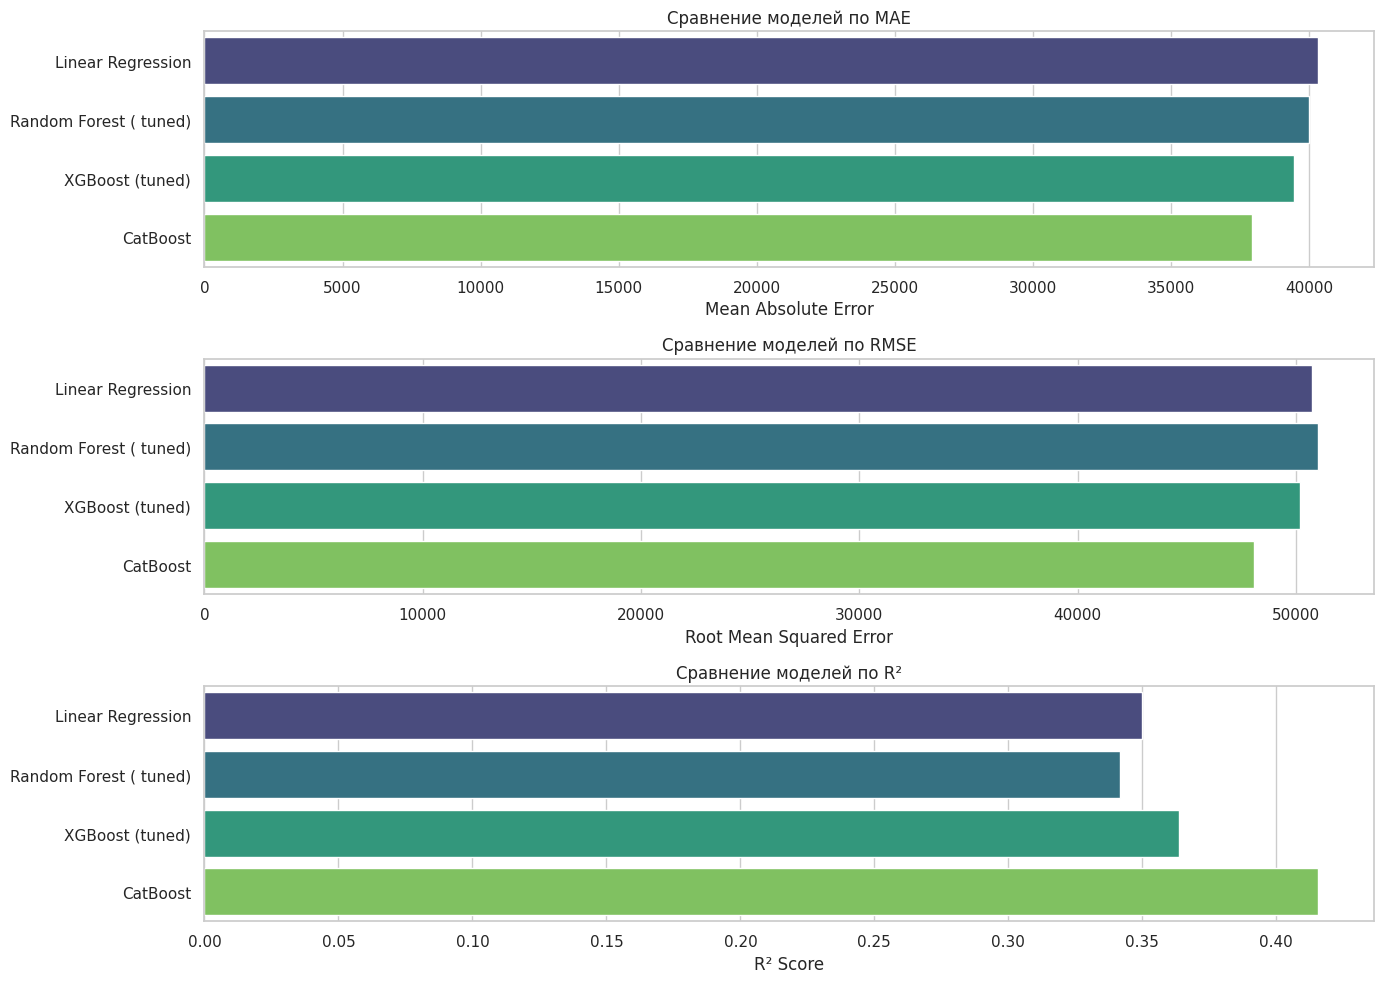

In [ ]:
results_df = pd.DataFrame(results)
print("\nРезультаты сравнения моделей:")
print(results_df)

# Визуализация результатов
plt.figure(figsize=(14, 10))

# MAE
plt.subplot(3, 1, 1)
sns.barplot(x='MAE', y='Model', data=results_df, palette='viridis')
plt.title('Сравнение моделей по MAE')
plt.xlabel('Mean Absolute Error')
plt.ylabel('')

# RMSE
plt.subplot(3, 1, 2)
sns.barplot(x='RMSE', y='Model', data=results_df, palette='viridis')
plt.title('Сравнение моделей по RMSE')
plt.xlabel('Root Mean Squared Error')
plt.ylabel('')

# R²
plt.subplot(3, 1, 3)
sns.barplot(x='R²', y='Model', data=results_df, palette='viridis')
plt.title('Сравнение моделей по R²')
plt.xlabel('R² Score')
plt.ylabel('')

plt.tight_layout()
plt.show()

/tmp/ipython-input-2595375339.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_importance, palette='rocket')


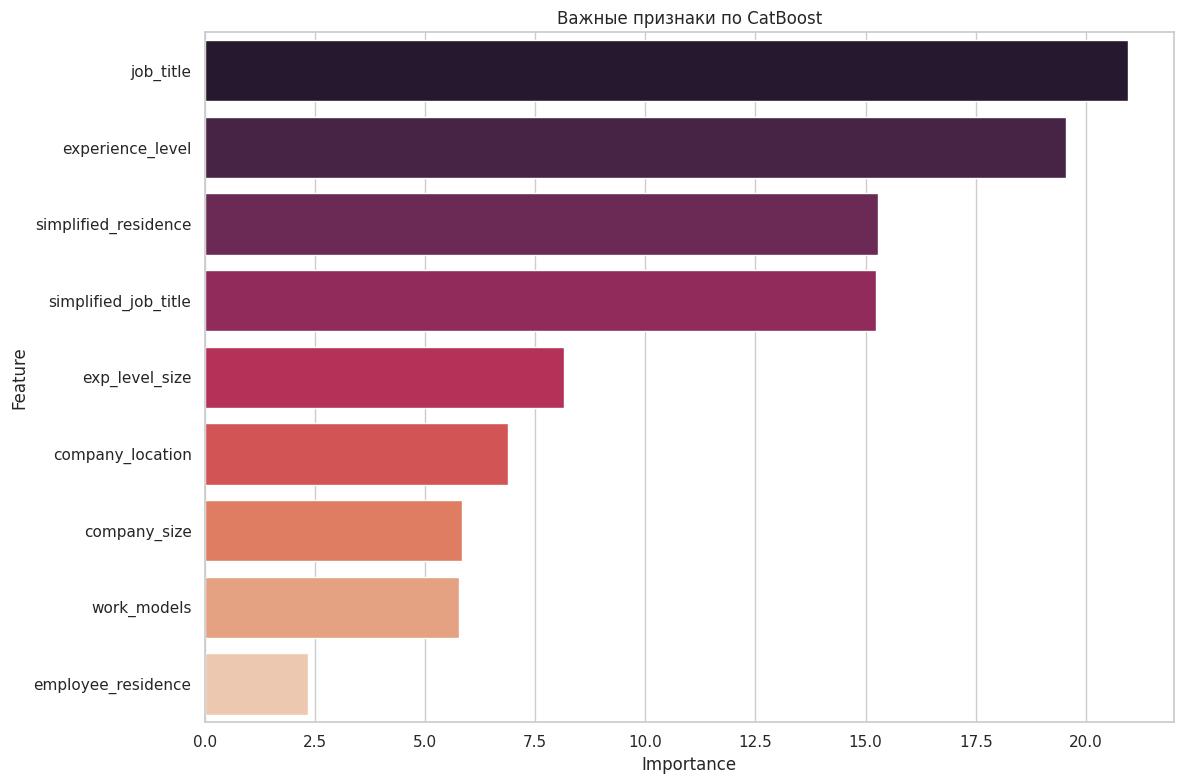

In [ ]:
best_model_idx = results_df['R²'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']

# Для CatBoost
feature_importance = catboost_model.get_feature_importance()
feature_names = catboost_model.feature_names_

# Создаем DataFrame для визуализации
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Берем топ-15 признаков
top_importance = importance_df.head(15)

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_importance, palette='rocket')
plt.title(f'Важные признаки по {best_model_name}')
plt.tight_layout()
plt.show()



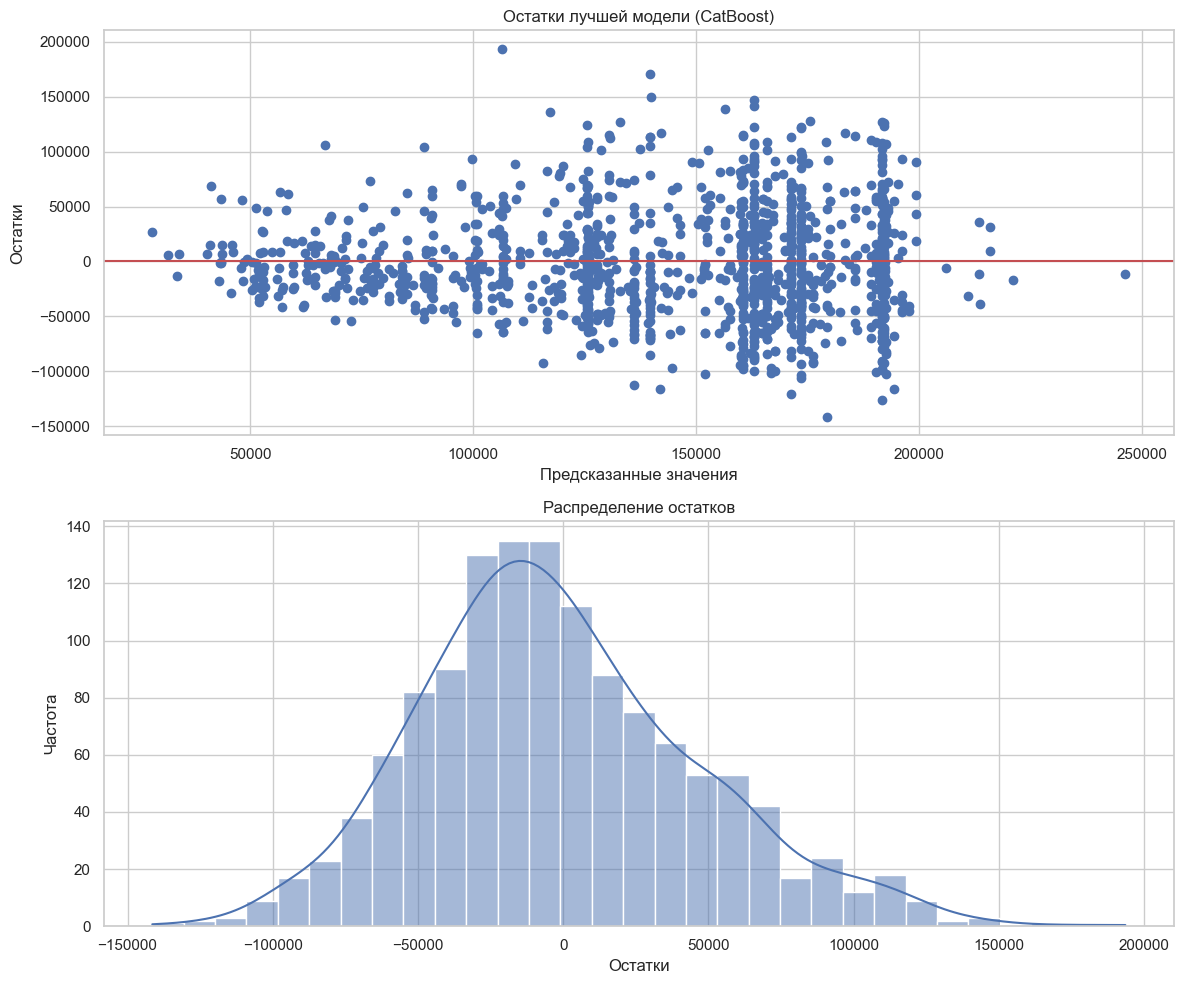

In [ ]:
best_model_idx = results_df['R²'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']

pred = catboost_pred
residuals = y_test.values - catboost_pred


# Визуализация остатков
plt.figure(figsize=(12, 10))

# График остатков
plt.subplot(2, 1, 1)
plt.scatter(pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title(f'Остатки лучшей модели ({best_model_name})')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')

# Распределение остатков
plt.subplot(2, 1, 2)
sns.histplot(residuals, kde=True)
plt.title('Распределение остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()